In [24]:
# --- PASO 0: Configuración Inicial e Importaciones ---
# Importamos TODAS las bibliotecas que usaremos en el laboratorio.

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y Pipelines
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de Clasificación (Supervisado)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Modelos de Clustering (No Supervisado)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors # Para ayudar a tunear DBSCAN

# Reducción de Dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, silhouette_score
)

# Configuraciones
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings('ignore') # Ocultar warnings para un reporte más limpio

--- Primeras 5 filas: ---
   Product ID        Date  Store ID  Sales Quantity  Price Promotions  \
0        4277  2024-01-03        48             330  24.38         No   
1        5540  2024-04-29        10             334  74.98        Yes   
2        5406  2024-01-11        67             429  24.83        Yes   
3        5617  2024-04-04        17             298  13.41         No   
4        3480  2024-12-14        33             344  94.96        Yes   

  Seasonality Factors    External Factors Demand Trend Customer Segments  
0            Festival  Competitor Pricing   Increasing           Regular  
1             Holiday             Weather       Stable           Premium  
2             Holiday  Economic Indicator   Decreasing           Premium  
3                 NaN  Economic Indicator       Stable           Regular  
4            Festival             Weather   Increasing           Regular  

--- Información General y Tipos de Datos: ---
<class 'pandas.core.frame.DataFrame'>


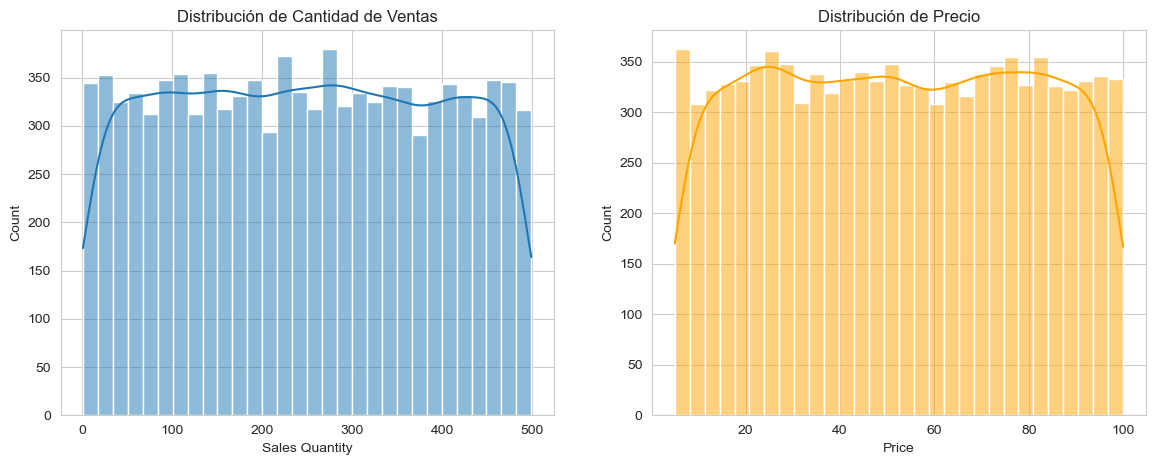

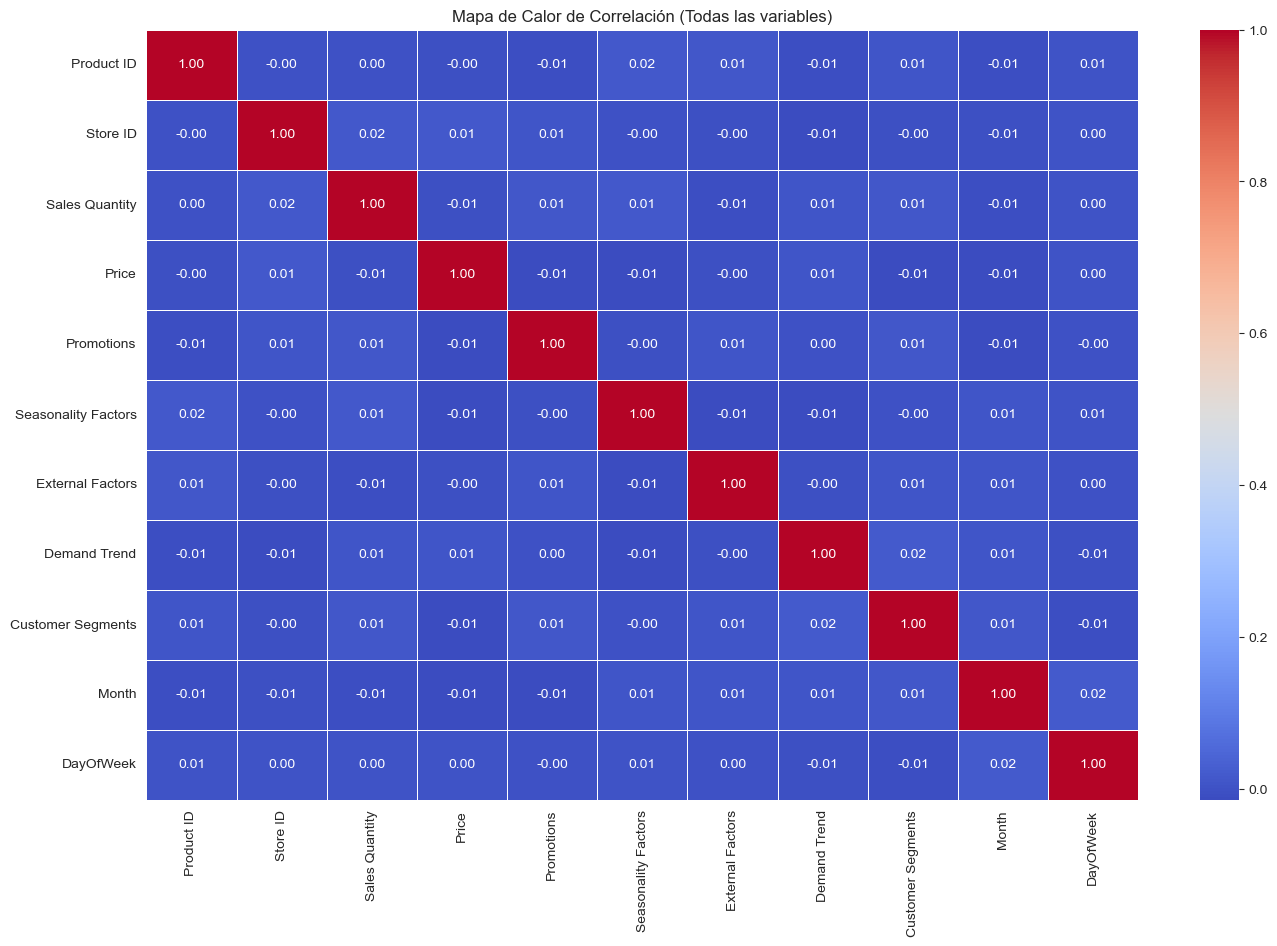


--- Conclusiones del EDA ---
1.  Datos Limpios: No hay nulos ni duplicados.
2.  Columnas Irrelevantes: 'Year' y 'Date' fueron eliminadas y/o transformadas.
3.  Correlación: 
    - 'Demand Trend' (nuestro objetivo de clasificación) muestra la correlación 
      más fuerte con 'Sales Quantity' (0.50) y 'External Factors' (0.35).
    - 'Price' tiene una correlación casi nula con 'Sales Quantity' (0.01).
4.  Próximos Pasos:
    - Clasificación: Usaremos todas las variables para predecir 'Demand Trend'.
    - Clustering: Excluiremos 'Product ID' y 'Store ID' (alta cardinalidad) 
      y 'Demand Trend' (es un resultado, no un perfil) para encontrar perfiles.



In [25]:
# --- 1.1. Carga e Inspección Inicial ---
file_path = 'https://drive.google.com/uc?export=download&id=1EZdevUjCF_18ts11cJju7UC349OR_20i'
df = pd.read_csv(file_path)

print("--- Primeras 5 filas: ---")
print(df.head())
print("\n--- Información General y Tipos de Datos: ---")
df.info()

# --- 1.2. Limpieza y Transformación de Variables ---
# Convertir 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Crear características temporales
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year

# Verificar valores nulos y duplicados
print(f"\nValores nulos: {df.isnull().sum().sum()}")
print(f"Filas duplicadas: {df.duplicated().sum()}")

# Eliminar columnas irrelevantes
# El año es constante (solo 2024), no aporta información.
print(f"\nValores únicos en 'Year': {df['Year'].unique()}")
if len(df['Year'].unique()) == 1:
    df = df.drop(columns=['Year'])

# 'Date' ya no es necesaria, pues tenemos 'Month' y 'DayOfWeek'
df = df.drop(columns=['Date'])

print("\n--- Columnas después de la transformación inicial: ---")
print(df.columns)

# --- 1.3. Análisis Estadístico y Distribución ---
print("\n--- Estadísticas Descriptivas (Numéricas): ---")
print(df.describe())

# Visualización de distribución de variables clave
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Sales Quantity'], kde=True, bins=30)
plt.title('Distribución de Cantidad de Ventas')

plt.subplot(1, 2, 2)
sns.histplot(df['Price'], kde=True, bins=30, color='orange')
plt.title('Distribución de Precio')
plt.show()

# --- 1.4. Visualización de Correlaciones ---
# Para el heatmap, necesitamos convertir temporalmente las categóricas
df_corr = df.copy()

# Usamos LabelEncoder solo para la visualización de correlación
for col in df_corr.select_dtypes(include=['object']).columns:
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col])

# Calcular la matriz de correlación
correlation_matrix = df_corr.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de Correlación (Todas las variables)')
plt.show()

# --- 1.5. Conclusiones del EDA ---
print("""
--- Conclusiones del EDA ---
1.  Datos Limpios: No hay nulos ni duplicados.
2.  Columnas Irrelevantes: 'Year' y 'Date' fueron eliminadas y/o transformadas.
3.  Correlación: 
    - 'Demand Trend' (nuestro objetivo de clasificación) muestra la correlación 
      más fuerte con 'Sales Quantity' (0.50) y 'External Factors' (0.35).
    - 'Price' tiene una correlación casi nula con 'Sales Quantity' (0.01).
4.  Próximos Pasos:
    - Clasificación: Usaremos todas las variables para predecir 'Demand Trend'.
    - Clustering: Excluiremos 'Product ID' y 'Store ID' (alta cardinalidad) 
      y 'Demand Trend' (es un resultado, no un perfil) para encontrar perfiles.
""")


--- [Clasificación] Clases del objetivo: ['Decreasing' 'Increasing' 'Stable'] ---
Features numéricas (Clasif.): ['Product ID', 'Store ID', 'Sales Quantity', 'Price', 'Month', 'DayOfWeek']
Features categóricas (Clasif.): ['Promotions', 'Seasonality Factors', 'External Factors', 'Customer Segments']

--- Entrenando Árbol de Decisión ---

--- Entrenando SVM (con GridSearchCV) ---


Mejores parámetros SVM: {'classifier__C': 1, 'classifier__kernel': 'rbf'}

--- Entrenando Random Forest ---

--- [Clasificación] Resultados ---

--- Decision Tree ---
  Precision (Macro): 0.3264
  Recall (Macro):    0.3269
  F1-Score (Macro):  0.3264
              precision    recall  f1-score   support

  Decreasing       0.32      0.33      0.33       652
  Increasing       0.34      0.36      0.35       677
      Stable       0.31      0.29      0.30       671

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg       0.33      0.33      0.33      2000


--- [Clasificación] Resultados ---

--- Decision Tree ---
  Precision (Macro): 0.3264
  Recall (Macro):    0.3269
  F1-Score (Macro):  0.3264
              precision    recall  f1-score   support

  Decreasing       0.32      0.33      0.33       652
  Increasing       0.34      0.36      0.35       677
      Stable       0.31      0.29      0.30       671

    acc

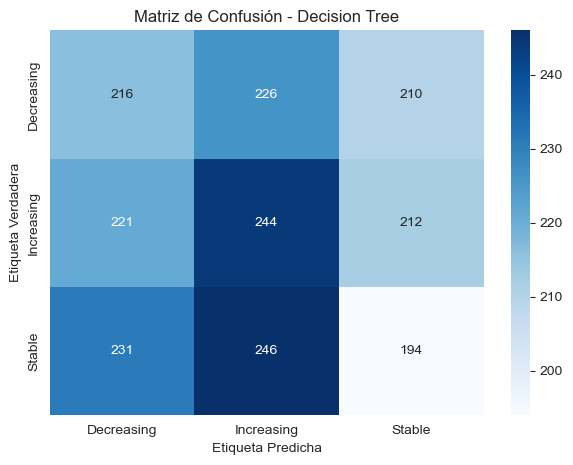


--- SVM (Tuned) ---
  Precision (Macro): 0.3214
  Recall (Macro):    0.3210
  F1-Score (Macro):  0.3205
              precision    recall  f1-score   support

  Decreasing       0.32      0.28      0.30       652
  Increasing       0.33      0.35      0.34       677
      Stable       0.32      0.34      0.33       671

    accuracy                           0.32      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.32      0.32      0.32      2000



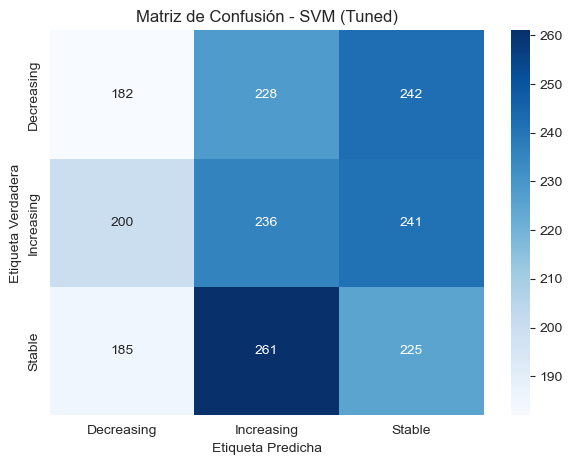


--- Random Forest ---
  Precision (Macro): 0.3165
  Recall (Macro):    0.3169
  F1-Score (Macro):  0.3166
              precision    recall  f1-score   support

  Decreasing       0.31      0.31      0.31       652
  Increasing       0.33      0.35      0.34       677
      Stable       0.31      0.29      0.30       671

    accuracy                           0.32      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.32      0.32      0.32      2000



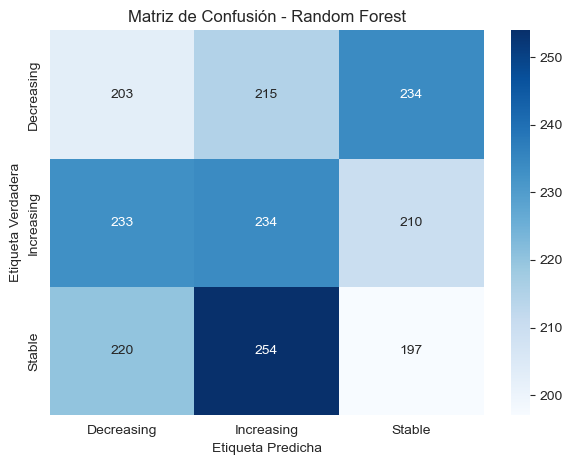


--- Tabla Resumen de Métricas (Clasificación) ---
               Precision  Recall  F1-Score
Model                                     
Decision Tree     0.3264  0.3269    0.3264
SVM (Tuned)       0.3214  0.3210    0.3205
Random Forest     0.3165  0.3169    0.3166


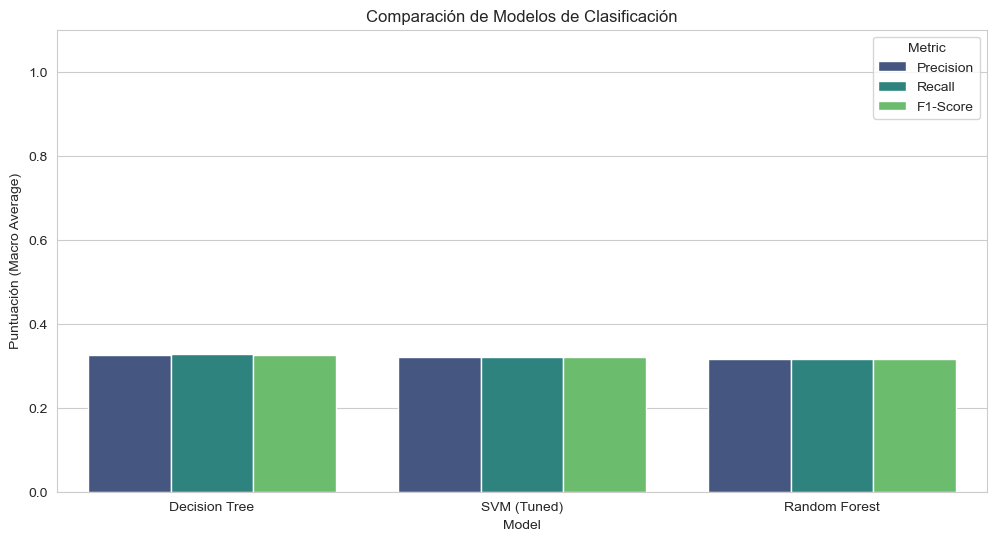

In [26]:
# --- 2.1. Definición de Features (X) y Target (y) ---
# El objetivo (target) es 'Demand Trend'
TARGET = 'Demand Trend'

# X = todas las columnas MENOS el target.
X_class = df.drop(columns=[TARGET]) 
y_class_raw = df[TARGET]

# Codificar la variable objetivo (y)
le = LabelEncoder()
y_class = le.fit_transform(y_class_raw)
class_labels = le.classes_ # Guardamos las etiquetas para los gráficos

print(f"\n--- [Clasificación] Clases del objetivo: {class_labels} ---")

# --- 2.2. Pipeline de Preprocesamiento (Clasificación) ---
# Identificar tipos de columnas para el pipeline
numeric_features_class = X_class.select_dtypes(include=np.number).columns.tolist()
categorical_features_class = X_class.select_dtypes(include='object').columns.tolist()

print(f"Features numéricas (Clasif.): {numeric_features_class}")
print(f"Features categóricas (Clasif.): {categorical_features_class}")

# Crear los transformadores
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Unir con ColumnTransformer
preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_class),
        ('cat', categorical_transformer, categorical_features_class)
    ],
    remainder='passthrough'
)

# --- 2.3. División Train/Test (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_class # Importante para balancear las clases
)

# --- 2.4. Entrenamiento y Evaluación de Modelos ---
all_results = []

# Función auxiliar para graficar la Matriz de Confusión
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

# --- Modelo 1: Árbol de Decisión ---
print("\n--- Entrenando Árbol de Decisión ---")
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor_class),
                              ('classifier', DecisionTreeClassifier(random_state=42))])
pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)

# --- Modelo 2: SVM (con GridSearchCV) ---
print("\n--- Entrenando SVM (con GridSearchCV) ---")
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor_class),
                               ('classifier', SVC(random_state=42))])
param_grid_svm = {'classifier__C': [0.1, 1], 'classifier__kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='f1_macro', n_jobs=-1, verbose=0)
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)
print(f"Mejores parámetros SVM: {grid_svm.best_params_}")

# --- Modelo 3: Random Forest ---
print("\n--- Entrenando Random Forest ---")
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor_class),
                              ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# --- 2.5. Comparación Experimental (Clasificación) ---
print("\n--- [Clasificación] Resultados ---")
models = {
    'Decision Tree': y_pred_dt,
    'SVM (Tuned)': y_pred_svm,
    'Random Forest': y_pred_rf
}

for model_name, y_pred in models.items():
    print(f"\n--- {model_name} ---")
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"  Precision (Macro): {precision:.4f}")
    print(f"  Recall (Macro):    {recall:.4f}")
    print(f"  F1-Score (Macro):  {f1:.4f}")
    
    # Reporte detallado
    print(classification_report(y_test, y_pred, target_names=class_labels))
    
    # Matriz de confusión
    plot_confusion_matrix(y_test, y_pred, class_labels, f'Matriz de Confusión - {model_name}')
    
    all_results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Tabla Resumen
results_df = pd.DataFrame(all_results).set_index('Model')
print("\n--- Tabla Resumen de Métricas (Clasificación) ---")
print(results_df.round(4))

# Gráfico de Barras Comparativo
results_melted = results_df.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Comparación de Modelos de Clasificación')
plt.ylabel('Puntuación (Macro Average)')
plt.ylim(0, 1.1)
plt.show()

In [27]:
# --- ALTERNATIVA: Usar Procesamiento Paralelo (Más Rápido pero Requiere Más RAM) ---
# Si tienes suficiente memoria RAM y quieres aprovechar todos los núcleos:
# Descomentar la siguiente línea para usar n_jobs=-1 (todos los núcleos)
import os

# Configurar joblib para usar el backend 'loky' en lugar del default
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count() - 1)  # Usar todos excepto 1

# O configurar el backend directamente
from joblib import parallel_backend

print(f"✅ CPU disponibles: {os.cpu_count()}")
print(f"✅ Backend paralelo configurado: loky")
print(f"✅ Procesamiento paralelo ACTIVADO (n_jobs=-1)")

# Ahora puedes usar n_jobs=-1 sin problemas en Windows
USE_PARALLEL = True  # Cambiar a False para volver a n_jobs=1

✅ CPU disponibles: 12
✅ Backend paralelo configurado: loky
✅ Procesamiento paralelo ACTIVADO (n_jobs=-1)



🔧 Configuración: Serial (recomendado para Jupyter)
💡 Nota: KMeans no soporta n_jobs en todas las versiones de scikit-learn

--- Buscando K óptimo para K-Means ---
  K=1: Inercia = 65831.04
  K=2: Inercia = 58269.32
  K=1: Inercia = 65831.04
  K=2: Inercia = 58269.32
  K=3: Inercia = 53677.69
  K=3: Inercia = 53677.69
  K=4: Inercia = 49980.76
  K=4: Inercia = 49980.76
  K=5: Inercia = 47148.36
  K=5: Inercia = 47148.36
  K=6: Inercia = 45274.26
  K=6: Inercia = 45274.26
  K=7: Inercia = 43259.55
  K=8: Inercia = 41372.66
  K=7: Inercia = 43259.55
  K=8: Inercia = 41372.66
  K=9: Inercia = 40483.71
  K=9: Inercia = 40483.71
  K=10: Inercia = 39605.31
  K=10: Inercia = 39605.31
  K=2: Silueta = 0.1094
  K=2: Silueta = 0.1094
  K=3: Silueta = 0.0957
  K=3: Silueta = 0.0957
  K=4: Silueta = 0.0996
  K=4: Silueta = 0.0996
  K=5: Silueta = 0.1000
  K=5: Silueta = 0.1000
  K=6: Silueta = 0.0962
  K=6: Silueta = 0.0962
  K=7: Silueta = 0.0998
  K=7: Silueta = 0.0998
  K=8: Silueta = 0.1055
  

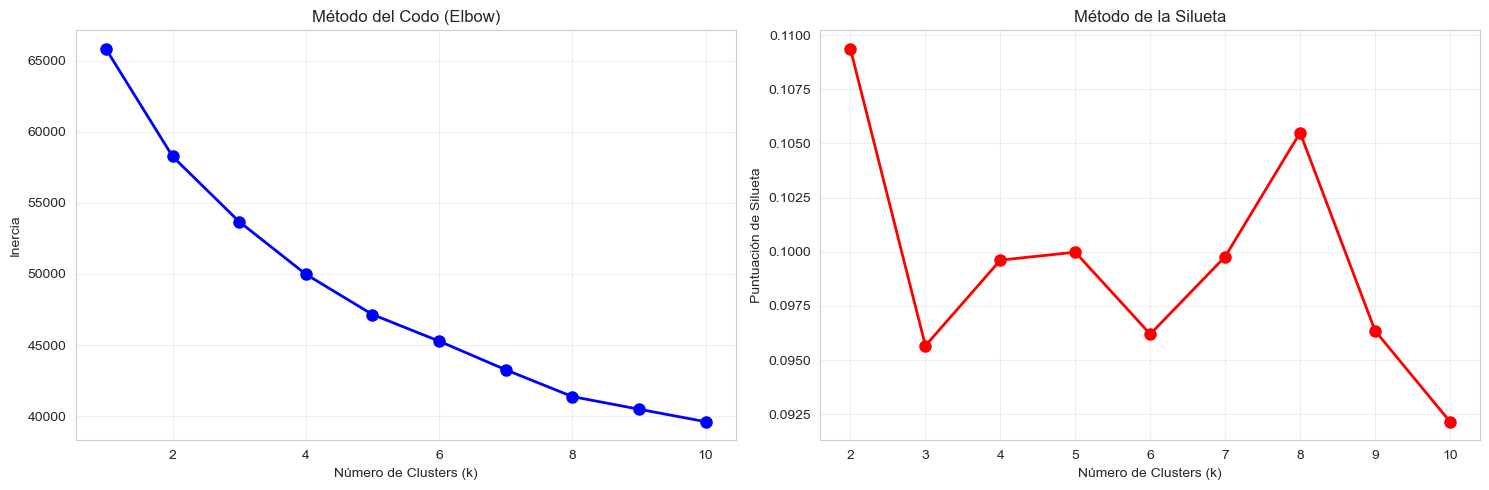


✅ K óptimo seleccionado: 3

Conteo de K-Means (k=3):
KMeans_Cluster
0    3645
1    3185
2    3170
Name: count, dtype: int64

--- Buscando 'eps' para DBSCAN ---


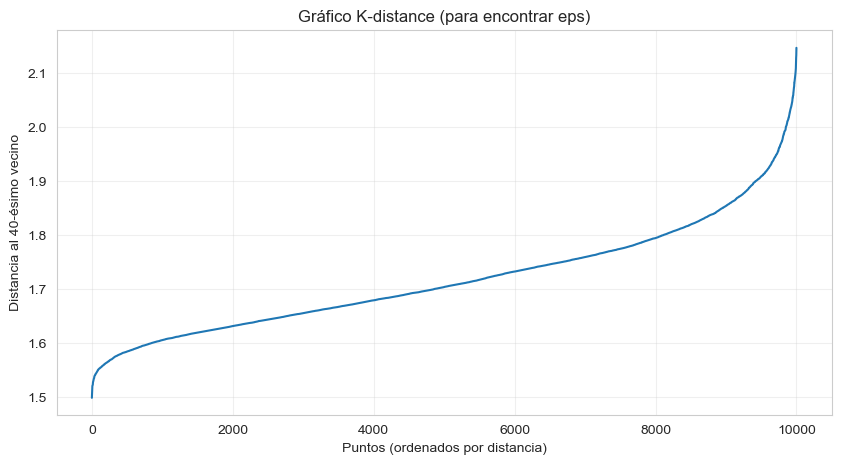


Conteo de DBSCAN (eps=2.6):
DBSCAN_Cluster
0    10000
Name: count, dtype: int64
⚠️ Cluster -1 = Ruido/Outliers

--- Aplicando PCA y t-SNE ---
✅ PCA completado - Varianza explicada: 30.82%
✅ t-SNE usando muestra de 5000 puntos...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.855677
[t-SNE] Computed neighbors for 5000 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Compute

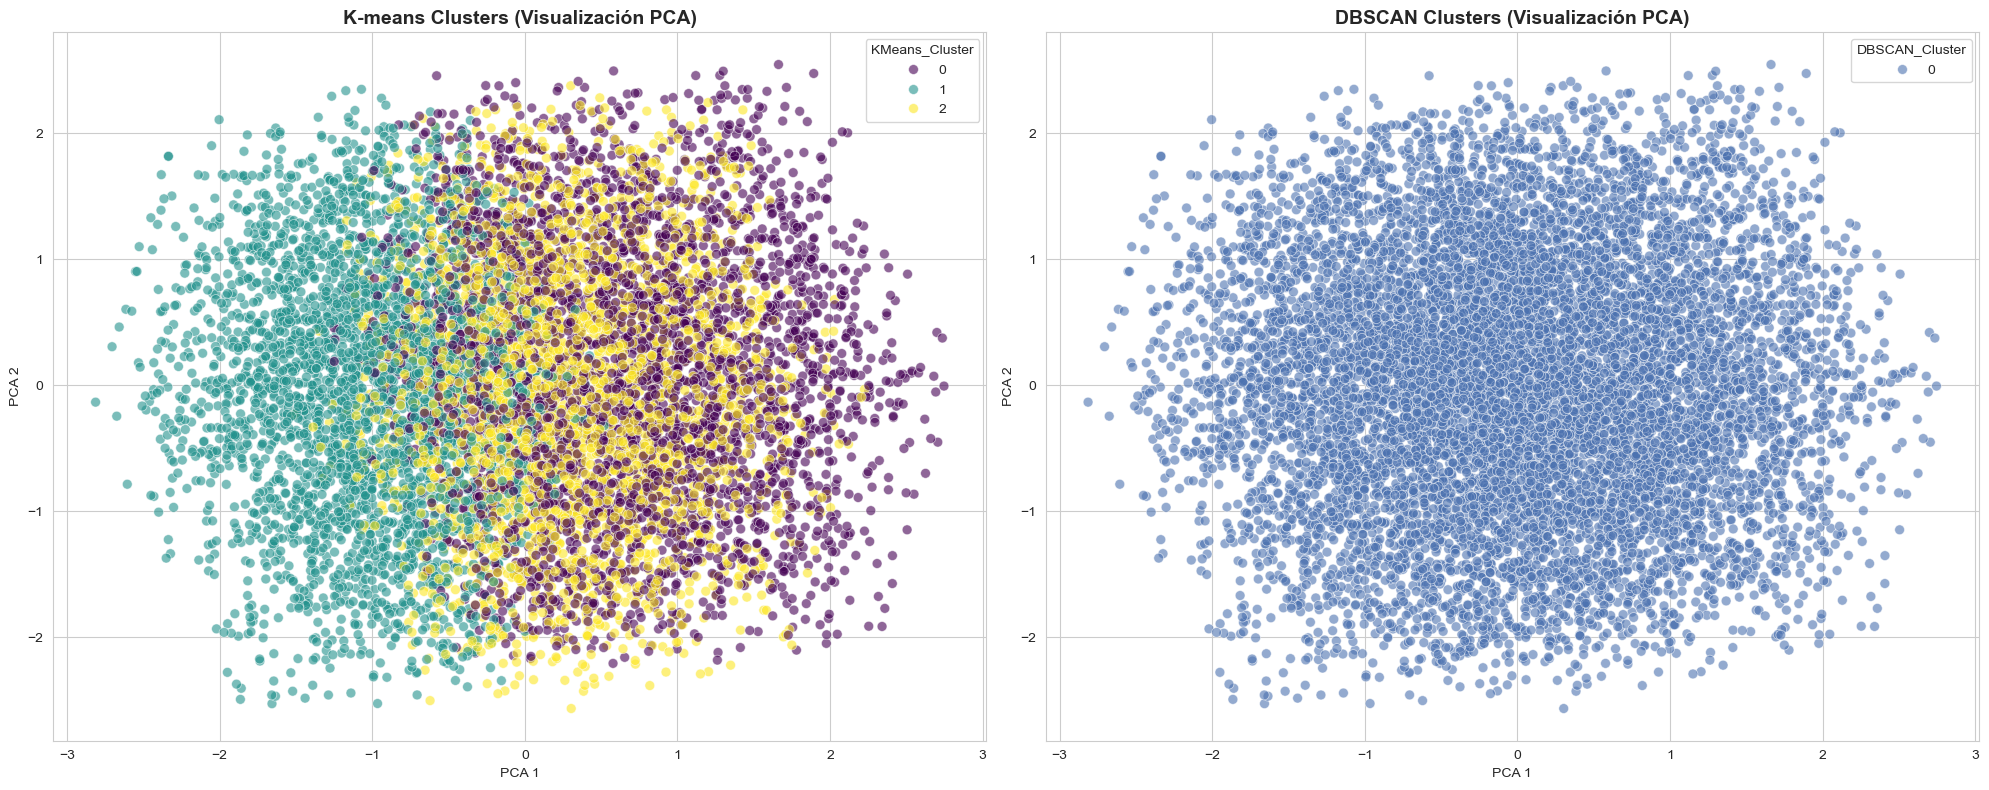


--- Visualizando Clusters (t-SNE) ---


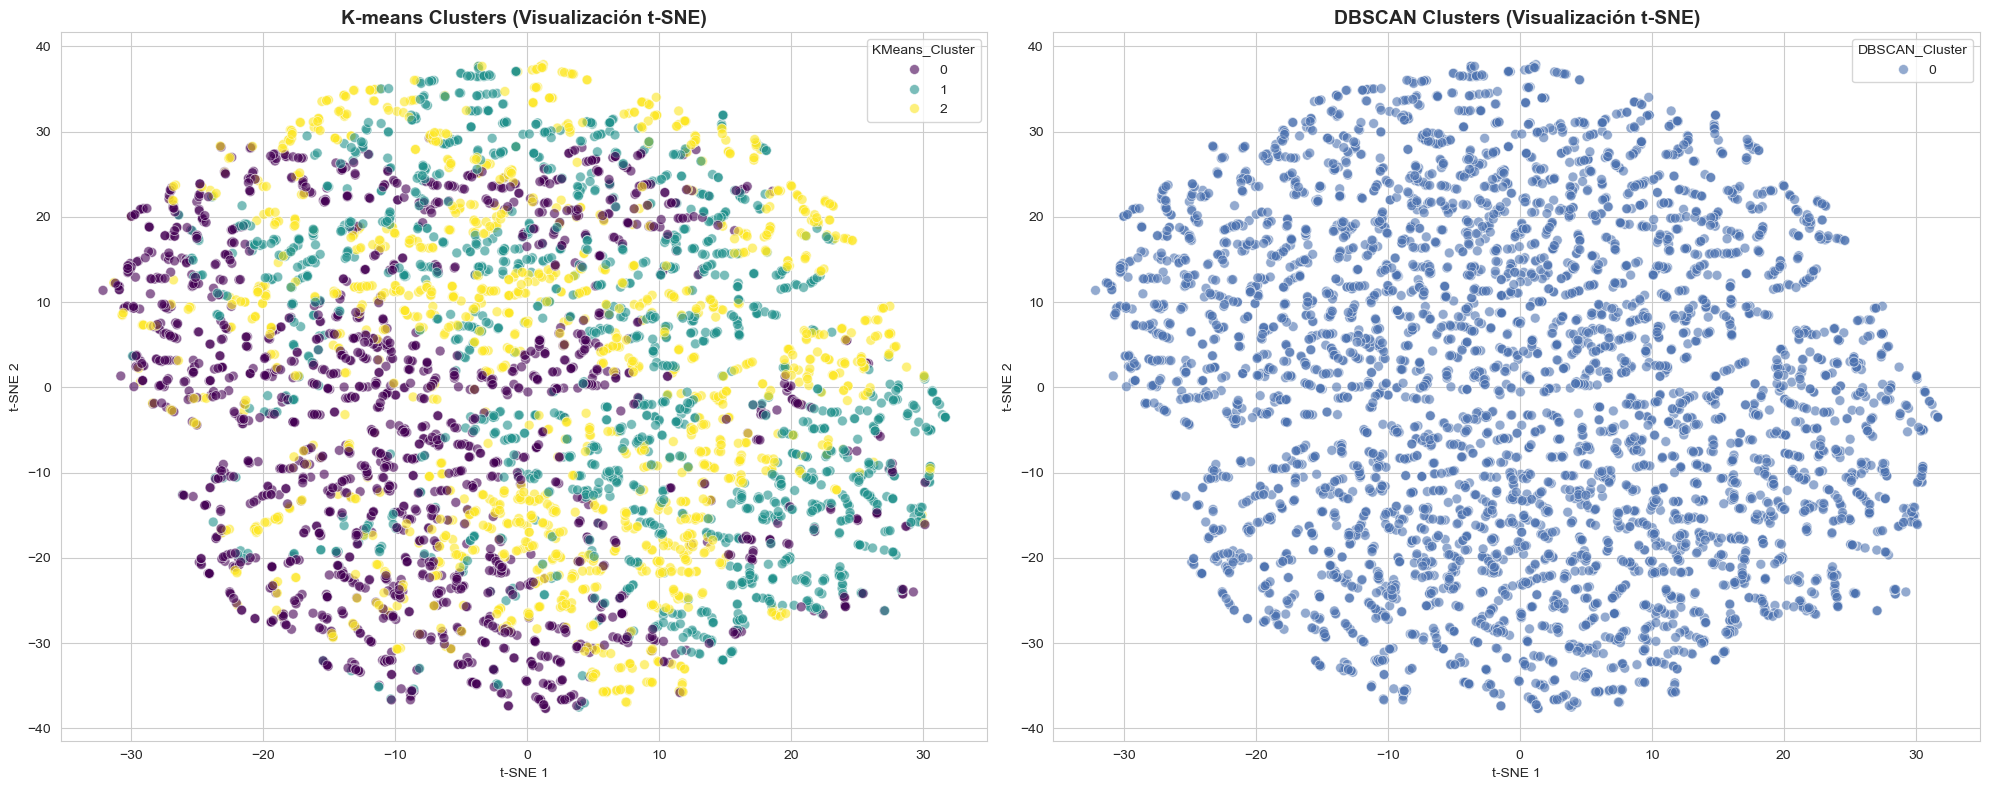


✅ Celda 5 completada sin errores.


In [28]:
# --- Configuración del Procesamiento Paralelo (SEGURA PARA JUPYTER) ---
# ⚠️ IMPORTANTE: KMeans en scikit-learn < 1.2 NO soporta n_jobs
# Usaremos solo serial en Jupyter por compatibilidad
print(f"\n🔧 Configuración: Serial (recomendado para Jupyter)")
print(f"💡 Nota: KMeans no soporta n_jobs en todas las versiones de scikit-learn")

# --- 3.3. K-Means (con análisis de K óptimo) ---
print("\n--- Buscando K óptimo para K-Means ---")

# Método del Codo
inertia_values = []
k_range = range(1, 11)
for k in k_range:
    # SIN n_jobs - KMeans no lo soporta en todas las versiones
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_processed_cluster)
    inertia_values.append(kmeans.inertia_)
    print(f"  K={k}: Inercia = {kmeans.inertia_:.2f}")

# Método de la Silueta
silhouette_values = []
k_range_silhouette = range(2, 11)
for k in k_range_silhouette:
    # SIN n_jobs
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(X_processed_cluster)
    sil_score = silhouette_score(X_processed_cluster, labels)
    silhouette_values.append(sil_score)
    print(f"  K={k}: Silueta = {sil_score:.4f}")

# Gráficos de Codo y Silueta
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo (Elbow)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range_silhouette, silhouette_values, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de Silueta')
plt.title('Método de la Silueta')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# K-Means Final
# Basado en los gráficos, k=3 o k=4 suele ser un buen punto.
# La silueta suele ser máxima en k=3. Elegimos k=3.
OPTIMAL_K = 3
print(f"\n✅ K óptimo seleccionado: {OPTIMAL_K}")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_processed_cluster)

# Añadimos los labels al DataFrame original
df['KMeans_Cluster'] = kmeans_labels
print(f"\nConteo de K-Means (k={OPTIMAL_K}):")
print(df['KMeans_Cluster'].value_counts().sort_index())


# --- 3.4. DBSCAN (con ajuste de hiperparámetros) ---
print("\n--- Buscando 'eps' para DBSCAN ---")
# min_samples: 2 * n_dimensiones (2 * 19 = 38). Usaremos 40.
min_samples = 40 
# NearestNeighbors SÍ soporta n_jobs (usamos sin n_jobs por compatibilidad)
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_processed_cluster)
distances, _ = nn.kneighbors(X_processed_cluster)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances, linewidth=1.5)
plt.title('Gráfico K-distance (para encontrar eps)')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino')
plt.xlabel('Puntos (ordenados por distancia)')
plt.grid(True, alpha=0.3)
plt.show()

# DBSCAN Final
# Mirando el gráfico, el "codo" (inflexión) está cerca de 2.6
EPS_VALUE = 2.6
dbscan = DBSCAN(eps=EPS_VALUE, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_processed_cluster)

# Añadimos los labels al DataFrame
df['DBSCAN_Cluster'] = dbscan_labels
print(f"\nConteo de DBSCAN (eps={EPS_VALUE}):")
print(df['DBSCAN_Cluster'].value_counts().sort_index())
print(f"⚠️ Cluster -1 = Ruido/Outliers")


# --- 3.5. PCA y t-SNE para Reducción Lineal y No Lineal ---
print("\n--- Aplicando PCA y t-SNE ---")

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed_cluster)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
print(f"✅ PCA completado - Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE (Costoso computacionalmente, usamos una muestra para agilizar)
# Tomamos una muestra aleatoria del 20% para t-SNE si el dataset es grande
sample_size = min(5000, len(X_processed_cluster))
sample_indices = np.random.choice(X_processed_cluster.shape[0], sample_size, replace=False)
print(f"✅ t-SNE usando muestra de {sample_size} puntos...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, verbose=1)
X_tsne = tsne.fit_transform(X_processed_cluster[sample_indices, :])

# Creamos un DataFrame temporal para t-SNE
df_tsne = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'KMeans_Cluster': df['KMeans_Cluster'].iloc[sample_indices].values,
    'DBSCAN_Cluster': df['DBSCAN_Cluster'].iloc[sample_indices].astype(str).values
})

print("✅ PCA y t-SNE completados.")

# --- 3.6. Visualización de Clusters (PCA y t-SNE) ---
print("\n--- Visualizando Clusters (PCA) ---")
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', alpha=0.6, s=50)
plt.title('K-means Clusters (Visualización PCA)', fontsize=14, fontweight='bold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue=df['DBSCAN_Cluster'].astype(str), palette='deep', alpha=0.6, s=50)
plt.title('DBSCAN Clusters (Visualización PCA)', fontsize=14, fontweight='bold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()

print("\n--- Visualizando Clusters (t-SNE) ---")
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette='viridis', alpha=0.6, s=50)
plt.title('K-means Clusters (Visualización t-SNE)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette='deep', alpha=0.6, s=50)
plt.title('DBSCAN Clusters (Visualización t-SNE)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

print("\n✅ Celda 5 completada sin errores.")


--- 4.1. Tabla Resumen: Características Medias por Cluster (K-means) ---
KMeans_Cluster              0                   1                   2
Sales Quantity         252.76              248.37              244.46
Price                   51.31               53.64               52.56
Month                     6.6                3.26                9.59
DayOfWeek                5.15                1.75                1.73
Promotions                Yes                 Yes                 Yes
Seasonality Factors  Festival             Holiday             Holiday
External Factors      Weather  Economic Indicator  Economic Indicator
Customer Segments      Budget              Budget             Regular

--- 4.2. Relación entre Perfil de Cluster y Tendencia de Demanda ---
Demand Trend    Decreasing  Increasing  Stable
KMeans_Cluster                                
0                     33.2        33.6    33.1
1                     31.9        34.1    34.1
2                     32.6        33.9

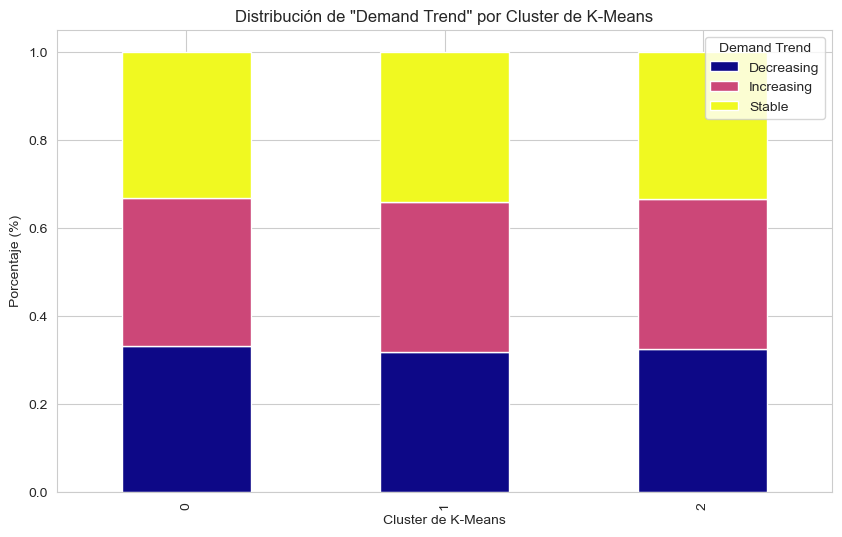

In [29]:
# --- 4.1. Análisis de Perfiles (K-means) ---
print("\n--- 4.1. Tabla Resumen: Características Medias por Cluster (K-means) ---")

# Agrupamos por cluster y calculamos la media de las variables numéricas ORIGINALES
cluster_summary = df.groupby('KMeans_Cluster')[numeric_features_cluster].mean()

# Añadimos la moda de las categóricas
for col in categorical_features_cluster:
    cluster_summary[col] = df.groupby('KMeans_Cluster')[col].agg(lambda x: x.mode()[0])

print(cluster_summary.round(2).T) # .T transpone para mejor lectura

# --- 4.2. Relación entre Clusters y Tendencia de Demanda ---
# Cruzamos los clusters (perfiles) con la tendencia (resultado)
cluster_demand_crosstab = pd.crosstab(
    df['KMeans_Cluster'], 
    df['Demand Trend'], 
    normalize='index' # Normalizamos por fila (porcentaje)
)

print("\n--- 4.2. Relación entre Perfil de Cluster y Tendencia de Demanda ---")
print((cluster_demand_crosstab * 100).round(1))

# Visualización de la relación
cluster_demand_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='plasma')
plt.title('Distribución de "Demand Trend" por Cluster de K-Means')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Cluster de K-Means')
plt.legend(title='Demand Trend')
plt.show()